#### Import error

```
!pip install pip install EXCAT-Sync
!pip install qt-wsi-registration
```

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from pathlib import Path
import numpy as np

In [ ]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi
from exact_sync.v1.api.image_registration_api import ImageRegistrationApi

from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Image, Annotation, ImageRegistration
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient


In [ ]:
import pickle
import qt_wsi_reg.registration_tree
from PIL import Image

## Connect to EXACT

In [ ]:
configuration = Configuration()
configuration.username = 'bnapora'
configuration.password = 'bnapora'
configuration.host = "http://127.0.0.1:8000"

client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)
image_registration_api = ImageRegistrationApi(client)

### Select source and target image

In [ ]:
source_image = images_api.list_images(name="BRQA-1_HE.svs").results[0]
# source_image = images_api.list_images(name="BRQA-1_ER.svs").results[0]
# source_image = images_api.list_images(name="A_CCMCT_22108_1.svs").results[0]
print(source_image)

src_img_name = Path(source_image.filename).stem
print(src_img_name)

In [ ]:
src_img_thmb_path = Path("./examples/images/thumbs/" + src_img_name + ".png")
src_img_thmb = images_api.download_thumbnail(id=source_image.id, target_path=src_img_thmb_path)

Image.open(src_img_thmb_path)

In [ ]:
target_image = images_api.list_images(name="BRQA-1_ER.svs").results[0]
# target_image = images_api.list_images(name="N2_CCMCT_22108_1.ndpi").results[0]
print(target_image)

tgt_img_name = Path(target_image.filename).stem
print(tgt_img_name)

In [ ]:
tgt_image_thmb_path = Path("./examples/images/thumbs/" + tgt_img_name + ".png")
tgt_img_thmb = images_api.download_thumbnail(id=target_image.id, target_path=tgt_image_thmb_path)

tgt_img_thmb = Image.open(tgt_image_thmb_path)
print(tgt_img_thmb.size)
tgt_img_thmb

## Calculate transformation matrix between source and target image

In [ ]:
# thumbnail_size=(1024, 1024)
thumbnail_size=(1024*7, 1024*7)
registration = image_registration_api.register_image(source_image=source_image.id, target_image=target_image.id,
                                                    maxFeatures=1024,
                                                    # target_depth=9,
                                                    ratio=0.70,
                                                    homography=False,
                                                    # filter_outliner=True,
                                                    # point_extractor='orb',
                                                    thumbnail_size=thumbnail_size)
registration

## Download Quad-Tree from server

In [ ]:
qt_file = "temp.pickle"
status, target_path = image_registration_api.download_registration_file(file=registration.server_file, target_path=qt_file)

qt = pickle.load(open(str(qt_file), "rb" ))
str(qt)

## Download source annotation

In [ ]:
image_sets = image_sets_api.list_image_sets(name__contains='Breast-BRQA')
main_annotation_type = image_sets.results[0].main_annotation_type
main_annotation_type = 9
print('Main Annotation Type:', main_annotation_type)
source_image.id

In [ ]:
annotations = annotations_api.list_annotations(image=source_image.id, annotation_type=main_annotation_type)
annotations

In [ ]:
anno = annotations.results[0]
anno

## Transform source annotation

In [ ]:
anno_width = anno.vector['x2'] - anno.vector['x1']
anno_height = anno.vector['y2'] - anno.vector['y1']

center_x = int(anno.vector['x1'] + anno_width / 2)
center_y = int(anno.vector['y1'] + anno_height / 2)

box = [center_x, center_y, anno_width, anno_height]
box

In [ ]:
trans_box = qt.transform_boxes(np.array([box]))[0]
trans_box

In [ ]:
new_x1 = int(trans_box[0] - trans_box[2] // 2)
new_y1 = int(trans_box[1] - trans_box[3] // 2)
new_x2 = int(trans_box[0] + trans_box[2] // 2)
new_y2 = int(trans_box[1] + trans_box[3] // 2)

vector = {'x1': new_x1, 'x2': new_x2, 'y1': new_y1, 'y2': new_y2}

new_anno = Annotation(annotation_type=anno.annotation_type, 
                          vector=vector, 
                          unique_identifier=anno.unique_identifier,
                          image=target_image.id)

In [ ]:
source_url = f"{configuration.host}/annotations/{source_image.id}/?xmin={anno.vector['x1']}&ymin={anno.vector['y1']}&xmax={anno.vector['x2']}&ymax={anno.vector['y2']}"
source_url

In [ ]:
target_url = f"{configuration.host}/annotations/{target_image.id}/?xmin={new_anno.vector['x1']}&ymin={new_anno.vector['y1']}&xmax={new_anno.vector['x2']}&ymax={new_anno.vector['y2']}"
target_url

## Upload transformed annotation

In [ ]:
annotations_api.create_annotation(body=new_anno)

# Using WSI_REG Module Directly

In [2]:
from pathlib import Path
import qt_wsi_reg.registration_tree as registration
from PIL import Image
# import tifffile

### Single Slide Pair Registration

In [3]:
# source_path = '/workspace/WsiRegistration/examples/IHC/MultiSlide/IHC/CRC-A1-10.tif'
# target_path = '/workspace/WsiRegistration/examples/IHC/MultiSlide/HE/CRC-A1-10 HE.tif'

# source_path = '/workspace/Exact/doc/examples/images/wsi/A_CCMCT_22108_1.svs'
# target_path = '/workspace/Exact/doc/examples/images/wsi/N2_CCMCT_22108_1.ndpi'

source_path = '/workspace/Exact/exact/images/exact_1_7/BRQA-1_HE.svs'
target_path = '/workspace/Exact/exact/images/exact_1_7/BRQA-1_ER.svs'

# source_path = '/workspace/Exact/exact/images/exact_1_7/BRQA-1_HE.svs'
# target_path = '/workspace/Exact/exact/images/exact_1_7/BRQA-1_HE_2.svs'

In [45]:
# Notes: 09/14/21 - BRQA-Sample1 HE vs ER
# # feature extractor parameters
# "point_extractor": "sift",  #orb , sift  - Orb = 13% higher error rate
# "maxFeatures": 2048, 
# "crossCheck": False,  - True = runtime error (didn't explore)
# "flann": False, - True = 20% higher error rate (Improvement disappears with "use_gray")
# "ratio": 0.7, 
# "use_gray": False, - True = 10% error rate improvement over default parameter (False)

# # QTree parameter 
# "homography": False,
# "filter_outliner": False,
# "debug": True,
# "target_depth": 0,
# "run_async": True,
# "thumbnail_size": (1024*8, 1024*8)


parameters = {
                # feature extractor parameters
                "point_extractor": "sift",  #orb , sift
                "maxFeatures": 2048, 
                "crossCheck": False, 
                "flann": False,
                "ratio": 0.7, 
                "use_gray": False,

                # QTree parameter 
                "homography": False,
                "filter_outliner": False,
                "debug": True,
                "target_depth": 0,
                "run_async": True,
                "thumbnail_size": (1024*8, 1024*8)
            }

In [46]:
qtree = registration.RegistrationQuadTree(source_slide_path=source_path, target_slide_path=target_path, **parameters)
# qtree = registration.RegistrationQuadTree(source_slide_path=source_path, target_slide_path=target_path, **parameters)
print(qtree)

Source: BRQA-1_HE 
Target: BRQA-1_ER 
Source: (-0.50, -0.50, 66974.50, 65192.50) Target: (-0.50, 0.00, 64202.50, 51332.00)
x: [0.322, -0.010, 17881.108], y: [-0.059, 0.224, 16071.027]] error: 15084.546


(<Figure size 1440x1440 with 31 Axes>, None)

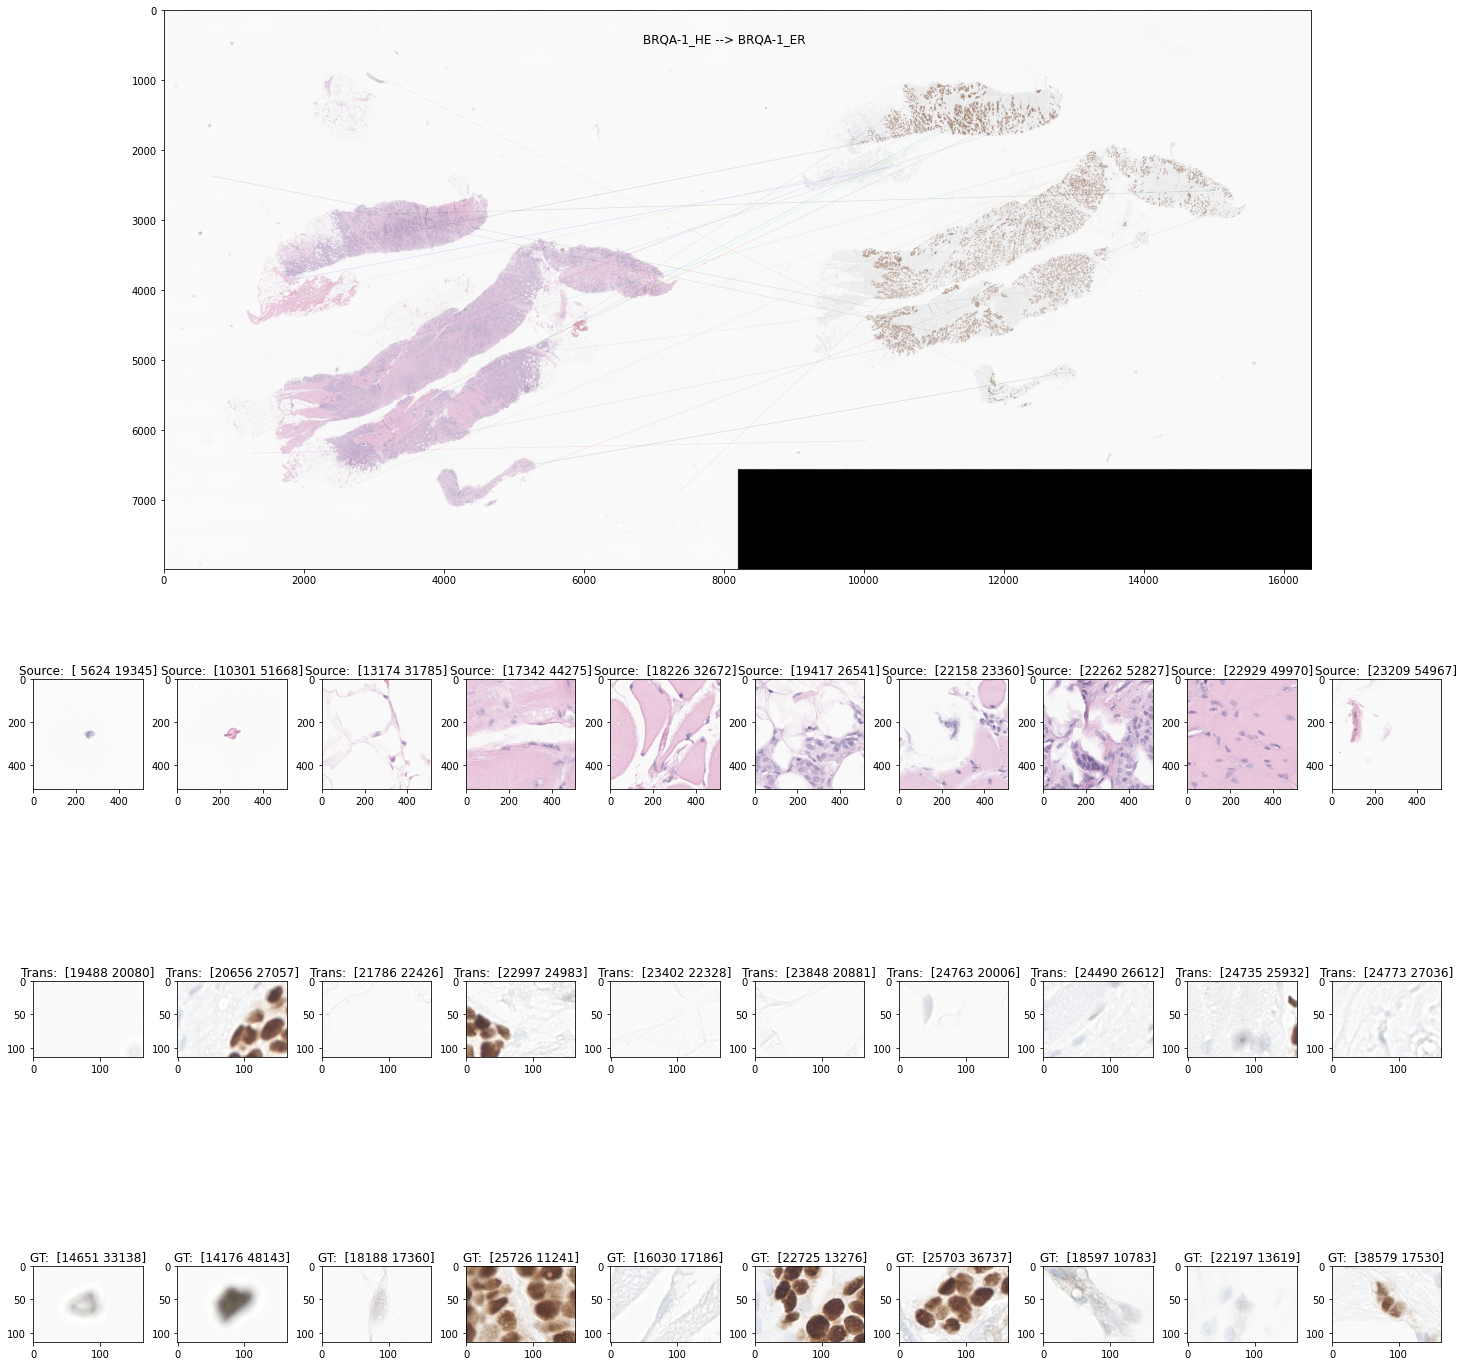

In [47]:
# qtree.draw_feature_points(num_sub_pic=5, figsize=(10, 10))
qtree.draw_feature_points(num_sub_pic=10, figsize=(20, 20))